### IMPUTING SALARY FROM INDEED.COM.AU SCRAPE.

The notebook reads in two Dataframes containing scraped information from indeed.com.au.

The first Dataframe contains scraped "data science" jobs and the second 'data analyst' jobs. Both have minimal salary information. The decision was made to bootstrap whatever salary information was available and test whether there is any difference between the two sample means. The p value for difference of sample salary means is shown below and is significant at the 99% CI level. Additionally, both Dataframes have a manually imputed salary label column. Ones were manually assigned for salary label within the data science Dataframe and zeros within the data analyst Dataframe.

In addition to bootstrapping the salary information a Kmeans clustering algorithm was used to assign title labels on the basis of job descriptions. The K means algorithm below has two centroids. Silhouette scores did not alter much from for higher k. There was also no statistical relationship between the resulting title labels and the salary labels.

Word clouds are produced for the two title label clusters. Visually there looks to be some separation of job titles between the two word clouds.


In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS 
from scipy.stats import chisquare
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
#Read data
def get_data():
    indeed_a= pd.read_csv('./indeed_anl')
    indeed_d= pd.read_csv('./indeed_d')
    #create salary labels, data science =1 , analyst=0
    indeed_a['salary_label']= np.zeros(161,)
    indeed_d['salary_label']= np.ones(217,)
    indeed_all= pd.concat([indeed_a,indeed_d]).drop(columns=('Unnamed: 0')) 
    return indeed_a, indeed_d, indeed_all

#clean salary, everything converted to annual salary amount.
def clean_salary(data):
    clean = data.apply(lambda x: x.lower().
                                   replace(',','.').replace('-','').replace('$',"")
                                   .replace('a day','').replace('a year','').replace('not shown','nan')
                                   .strip(','))
    numbers=clean[clean != 'nan']    
    
    yrly=[]
    for num in numbers:   
        for n in num.split():         
            if len(n) <=3:             
                yrly.append(float(n)*365)             
            else:
                yrly.append(float(n)*1000) 
    return np.array(yrly).astype(int)
    
    
#generate bootsrap salary samples    
def bootstrap(sample, stat_func, iters=10000):
    boots = []
    for i in range(iters):
        random_sample = np.random.choice(sample, replace=True, size=len(sample))
        stat = stat_func(random_sample)
        boots.append(stat)
    return np.array(boots).astype(int) 

def compare_salaries(salary_analyst,salary_data_scientist):
    fig = plt.figure(figsize=(10, 7))
    ax=sns.distplot(salary_data_scientist,hist=False,color='r',label='Data Scientist') 
    ax=sns.distplot(salary_analyst,hist=False, color='b',label='Data Analyst')
    print('')
    print('T-Statistic : difference of the two salary group means.')
    print(stats.ttest_ind(salary_analyst,salary_data_scientist))
    print('')
    ax.set_title('Analyst and Data Scientist Average Salaries',size = 15) 
    ax.set_xlabel('Average Salary',size = 10)
    plt.show()


#Generate labels for job titles using TFIDF and Kmeans. Use k=2
def create_title_labels(data):
    vec= TfidfVectorizer(max_features=30,min_df=.05,max_df=.95)
    X_dtm=vec.fit_transform(data)     
    k_mean = KMeans(n_clusters=2)
    k_mean.fit(X_dtm.todense())
    print('silhouette score for title label clusters =', silhouette_score(X_dtm, k_mean.labels_))
    return  k_mean.labels_  

#Use Chisquared test to see if there is a link between salary labels and job title labels
def compare_labels(data):    
    data_slice_comparison=np.array(data.iloc[:,-2:])
    print('Chi squared test for relationship between title labels and salary labels')
    print(chisquare(data_slice_comparison, axis=None))

#Produce Tag clouds
def produce_wordclouds(data):   
    print('')
    title_1=data[data['title_labels']== 0]
    title_2=data[data['title_labels']== 1]
  
    #prep for wordclouds
    titles={1: str(title_1['title']),
       2: str(title_2['title']), 
      }
    
    stopwords = set(STOPWORDS) 

    for t in titles.values():    
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='orange', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(t) 
        plt.figure(figsize = (6, 6), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show() 
        
        
#Bootstrap salary from data scientist and analyst samples         
def compare_salary_bands():            
    indeed_a=get_data()[0]    
    indeed_d=get_data()[1]    
    indeed_all=get_data()[2] 
    salary_analyst= bootstrap(clean_salary(indeed_a['salary']), np.mean, iters=50000) 
    salary_data_scientist= bootstrap(clean_salary(indeed_d['salary']), np.mean, iters=50000)
    print('Average Analyst salary:',int(np.mean(salary_analyst)))
    print('Average Data Scientist salary:',int(np.mean(salary_data_scientist)))
    compare_salaries(salary_analyst,salary_data_scientist) 
    
#Compare salary labels with title labels.      
def compare_title_salary_labels():
    indeed_all=get_data()[2]
    indeed_all['title_labels']=create_title_labels(indeed_all['title']) 
    print('')
    compare_labels(indeed_all) 
    print('')    
    produce_wordclouds(indeed_all)
    

Average Analyst salary: 108082
Average Data Scientist salary: 128725

T-Statistic : difference of the two salary group means.
Ttest_indResult(statistic=-573.8778037912055, pvalue=0.0)



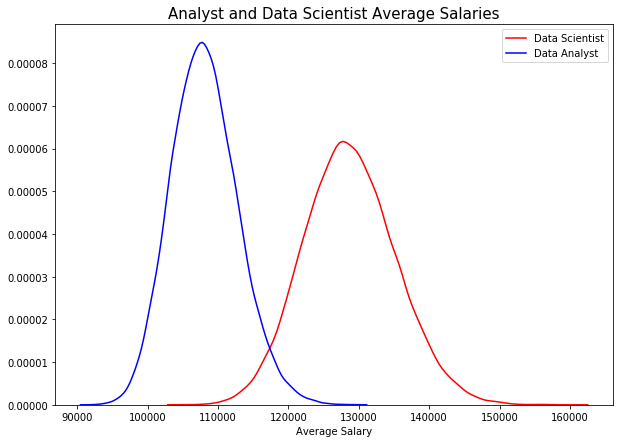

In [3]:
#call function to compary salaries
compare_salary_bands()    

silhouette score for title label clusters = 0.2759539831120823

Chi squared test for relationship between title labels and salary labels
Power_divergenceResult(statistic=381.0, pvalue=1.0)




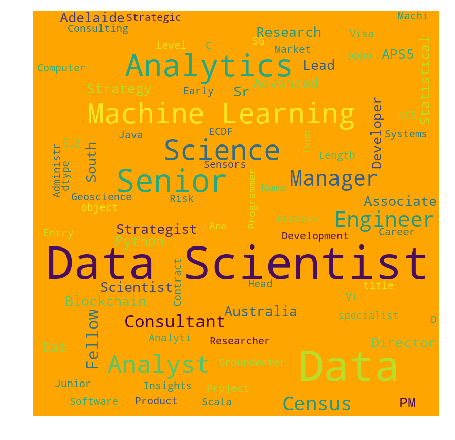

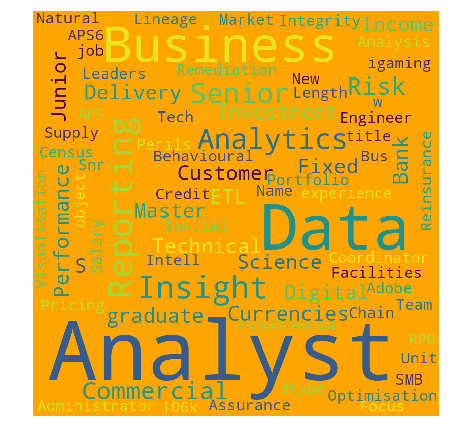

In [4]:
#Call function to compare salary and title labels
compare_title_salary_labels()  